# Import

In [1]:
from main import ArduinoReader
from motion_stages import Zaber_2axis_LST1500D as motion_stage
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set to Center

In [2]:
stage = motion_stage()
stage.home_axes()

In [3]:
# initialize stage instance and zero axes
x_center = 1160.0  # in mm
y_center = 260.0  # in mm
stage.move_x_absolute(x_center)
stage.move_y_absolute(y_center)

# initialize ArduinoReader


# Initialize Arduino

In [4]:
arduino = ArduinoReader('COM7', 9600)  # replace with your port 

# Callibrate

Iteration 1 - Calibration factor for X: -0.04452359750667854
Iteration 1 - Calibration factor for Y: -0.046189376443418015
Iteration 2 - Calibration factor for X: -0.044306601683650866
Iteration 2 - Calibration factor for Y: -0.046296296296296294
Iteration 3 - Calibration factor for X: -0.044444444444444446
Iteration 3 - Calibration factor for Y: -0.04589261128958238
Iteration 4 - Calibration factor for X: -0.04450378282153983
Iteration 4 - Calibration factor for Y: -0.045829514207149404
Iteration 5 - Calibration factor for X: -0.04440497335701599
Iteration 5 - Calibration factor for Y: -0.04589261128958238
Iteration 6 - Calibration factor for X: -0.044444444444444446
Iteration 6 - Calibration factor for Y: -0.04568296025582458
Iteration 7 - Calibration factor for X: -0.044543429844097995
Iteration 7 - Calibration factor for Y: -0.04601932811780948
Iteration 8 - Calibration factor for X: -0.04452359750667854
Iteration 8 - Calibration factor for Y: -0.045829514207149404
Iteration 9 - Ca

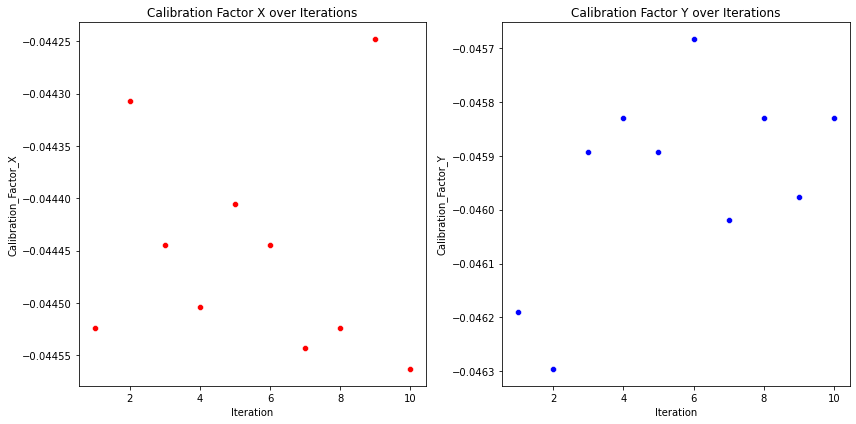


Descriptive statistics for Calibration Factor X:
count    10.000000
mean     -0.044451
std       0.000105
min      -0.044563
25%      -0.044524
50%      -0.044474
75%      -0.044415
max      -0.044248
Name: Calibration_Factor_X, dtype: float64

Descriptive statistics for Calibration Factor Y:
count    10.000000
mean     -0.045944
std       0.000184
min      -0.046296
25%      -0.046009
50%      -0.045893
75%      -0.045830
max      -0.045683
Name: Calibration_Factor_Y, dtype: float64

On average, one millimeter in the x direction is equivalent to -0.04445059390765676 in sensor readings.
On average, one millimeter in the y direction is equivalent to -0.045943873780821425 in sensor readings.


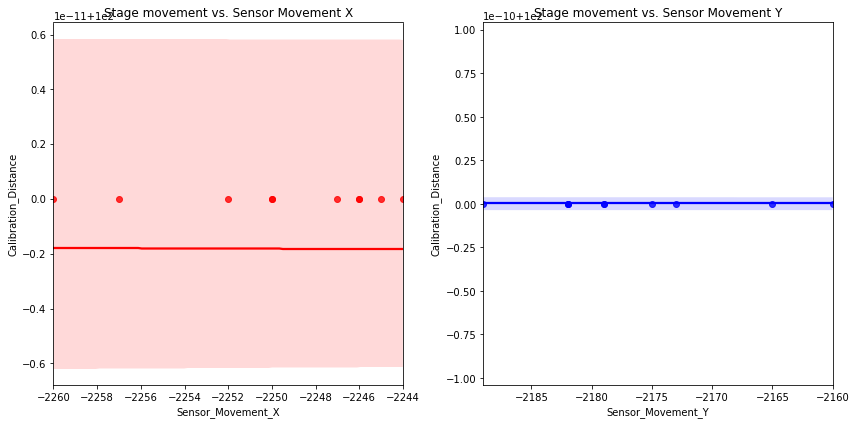

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calibrate the sensor
# Set the calibration distance, in mm. The greater the distance, the more accurate the calibration.
calibration_distance = 100.0  # in mm

N_iterations = 10
calibration_results = []

for i in range(N_iterations):
    stage.move_x_absolute(x_center)
    stage.move_y_absolute(y_center)
    time.sleep(5)

    # Record initial sensor readings
    initial_sensor_x, initial_sensor_y = arduino.distanceSinceInit()

    # Move the stage
    stage.move_x_absolute(x_center - calibration_distance)
    stage.move_y_absolute(y_center - calibration_distance)
    time.sleep(5)

    # Record sensor readings after moving
    final_sensor_x, final_sensor_y = arduino.distanceSinceInit()

    # Calculate the sensor's reported movement
    sensor_movement_x = final_sensor_x - initial_sensor_x
    sensor_movement_y = final_sensor_y - initial_sensor_y

    # Calculate calibration factors
    calibration_factor_x = calibration_distance / sensor_movement_x
    calibration_factor_y = calibration_distance / sensor_movement_y

    # Print calibration factors
    print(f"Iteration {i+1} - Calibration factor for X: {calibration_factor_x}")
    print(f"Iteration {i+1} - Calibration factor for Y: {calibration_factor_y}")

    calibration_results.append({
        'Iteration': i+1,
        'Calibration_Factor_X': calibration_factor_x,
        'Calibration_Factor_Y': calibration_factor_y,
        'Sensor_Movement_X': sensor_movement_x,
        'Sensor_Movement_Y': sensor_movement_y,
        'Calibration_Distance': calibration_distance,
        'Initial_Sensor_X': initial_sensor_x,
        'Initial_Sensor_Y': initial_sensor_y,
        'Final_Sensor_X': final_sensor_x,
        'Final_Sensor_Y': final_sensor_y,
    })

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(calibration_results)

# Append the dataframe to the existing CSV file
with open('calibration_script_results.csv', 'a') as f:
    df.to_csv(f, header=f.tell()==0, index=False)

# Scatter plot of Calibration Factors X and Y over the iterations
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x="Iteration", y="Calibration_Factor_X", color='r')
plt.title('Calibration Factor X over Iterations')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x="Iteration", y="Calibration_Factor_Y", color='b')
plt.title('Calibration Factor Y over Iterations')

plt.tight_layout()
plt.show()

# Print out descriptive statistics of the calibration factors
print("\nDescriptive statistics for Calibration Factor X:")
print(df['Calibration_Factor_X'].describe())
print("\nDescriptive statistics for Calibration Factor Y:")
print(df['Calibration_Factor_Y'].describe())

# Calculate average calibration factors
average_calibration_factor_x = df['Calibration_Factor_X'].mean()
average_calibration_factor_y = df['Calibration_Factor_Y'].mean()

print(f"\nOn average, one millimeter in the x direction is equivalent to {average_calibration_factor_x} in sensor readings.")
print(f"On average, one millimeter in the y direction is equivalent to {average_calibration_factor_y} in sensor readings.")

# Scatter plot of stage movement vs sensor movement for X and Y directions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.regplot(data=df, x="Sensor_Movement_X", y="Calibration_Distance", color='r')
plt.title('Stage movement vs. Sensor Movement X')

plt.subplot(1, 2, 2)
sns.regplot(data=df, x="Sensor_Movement_Y", y="Calibration_Distance", color='b')
plt.title('Stage movement vs. Sensor Movement Y')

plt.tight_layout()
plt.show()

# cleanup
arduino.stop()



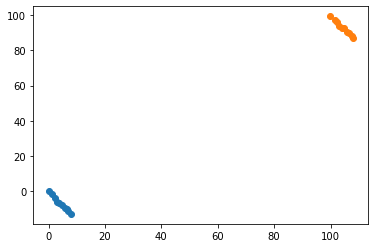

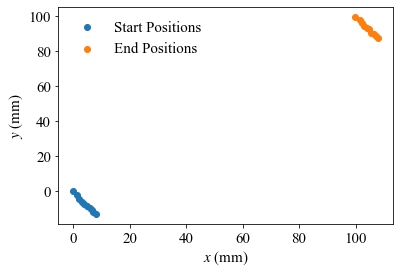

In [6]:
initial_x = []
initial_y = []
final_x = []
final_y = []
calibration_factors_x = []
calibration_factors_y = []
for i in range(len(calibration_results)):
    initial_x.append(calibration_results[i]['Initial_Sensor_X'])
    initial_y.append(calibration_results[i]['Initial_Sensor_Y'])
    final_x.append(calibration_results[i]['Final_Sensor_X'])
    final_y.append(calibration_results[i]['Final_Sensor_Y'])
    calibration_factors_x.append(calibration_results[i]['Calibration_Factor_X'])
    calibration_factors_y.append(calibration_results[i]['Calibration_Factor_Y'])
initial_x = np.array(initial_x)
initial_y = np.array(initial_y)
final_x = np.array(final_x)
final_y = np.array(final_y)
calibration_factors_x = np.array(calibration_factors_x)
calibration_factors_y = np.array(calibration_factors_y)

mean_calibration_factor_x = np.mean(calibration_factors_x)
mean_calibration_factor_y = np.mean(calibration_factors_y)

plt.figure()
plt.scatter(mean_calibration_factor_x*(initial_x - initial_x[0]), mean_calibration_factor_y*(initial_y - initial_y[0]))
plt.scatter(mean_calibration_factor_x*final_x, mean_calibration_factor_y*final_y)
plt.show()

%matplotlib inline
rc = {"font.size": 15,
      "font.family": 'Times New Roman',
      "mathtext.fontset": "stix"}
plt.rcParams.update(rc)

plt.figure()
plt.scatter(mean_calibration_factor_x*(initial_x - initial_x[0]), mean_calibration_factor_y*(initial_y - initial_y[0]), label='Start Positions')
plt.scatter(mean_calibration_factor_x*final_x, mean_calibration_factor_y*final_y, label='End Positions')
plt.xlabel('$x$ (mm)')
plt.ylabel('$y$ (mm)')
plt.legend(frameon=False)
plt.show()
# Creating a function to calculate distance
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Get the mean calibration factors
mean_calibration_factor_x = np.mean(calibration_factors_x)
mean_calibration_factor_y = np.mean(calibration_factors_y)

# Convert sensor units to mm
initial_x_mm = mean_calibration_factor_x * (initial_x - initial_x[0])
initial_y_mm = mean_calibration_factor_y * (initial_y - initial_y[0])
final_x_mm = mean_calibration_factor_x * final_x
final_y_mm = mean_calibration_factor_y * final_y

# Calculate the mean initial and final positions
mean_initial_x_mm = np.mean(initial_x_mm)
mean_initial_y_mm = np.mean(initial_y_mm)
mean_final_x_mm = np.mean(final_x_mm)
mean_final_y_mm = np.mean(final_y_mm)

# Calculate the distances of each point from the mean initial and final positions
initial_distances_mm = calculate_distance(initial_x_mm, initial_y_mm, mean_initial_x_mm, mean_initial_y_mm)
final_distances_mm = calculate_distance(final_x_mm, final_y_mm, mean_final_x_mm, mean_final_y_mm)

# Plot the start and end positions
plt.figure()
plt.scatter(initial_x_mm, initial_y_mm, label='Start Positions')
plt.scatter(final_x_mm, final_y_mm, label='End Positions')

# Mark the mean initial and final positions
plt.scatter(mean_initial_x_mm, mean_initial_y_mm, color='green', s=100, label='Expected Start')
plt.scatter(mean_final_x_mm, mean_final_y_mm, color='red', s=100, label='Expected Stop')

plt.xlabel('$x$ (mm)')
plt.ylabel('$y$ (mm)')
plt.legend(frameon=False)
plt.show()

# Print out descriptive statistics for the distances of each start and stop position from the mean start and stop positions
print("\nDescriptive statistics for Start Distance (in mm):")
print(np.mean(initial_distances_mm), np.std(initial_distances_mm))
print("\nDescriptive statistics for Stop Distance (in mm):")
print(np.mean(final_distances_mm), np.std(final_distances_mm))


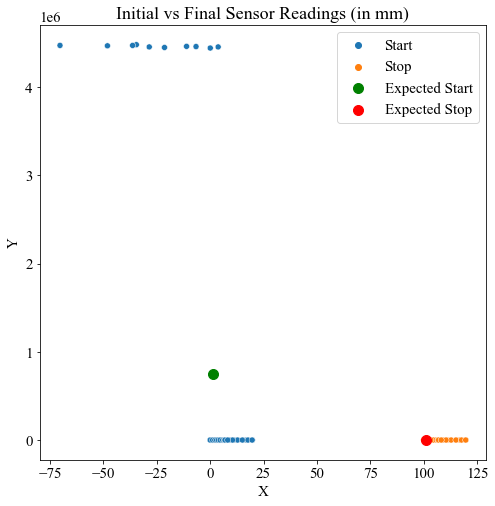


Descriptive statistics for Start Distance (in mm):
count    6.000000e+01
mean     1.239621e+06
std      1.118117e+06
min      7.437676e+05
25%      7.437698e+05
50%      7.437731e+05
75%      7.437783e+05
max      3.737885e+06
Name: Start_Distance_mm, dtype: float64

Descriptive statistics for Stop Distance (in mm):
count    50.000000
mean      7.101600
std       4.315830
min       1.086896
25%       4.271558
50%       5.631704
75%       8.946864
max      18.653651
Name: Stop_Distance_mm, dtype: float64


In [7]:



import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle

# Load the calibration results from the CSV file
df = pd.read_csv('calibration_script_results.csv')

# Convert sensor readings to mm using the calibration factors
df['Initial_Sensor_X_mm'] = df['Initial_Sensor_X'] * df['Calibration_Factor_X']
df['Initial_Sensor_Y_mm'] = df['Initial_Sensor_Y'] * df['Calibration_Factor_Y']
df['Final_Sensor_X_mm'] = df['Final_Sensor_X'] * df['Calibration_Factor_X']
df['Final_Sensor_Y_mm'] = df['Final_Sensor_Y'] * df['Calibration_Factor_Y']

# Define a new DataFrame for plotting purpose
plot_df = pd.concat([
    df[['Initial_Sensor_X_mm', 'Initial_Sensor_Y_mm']].rename(columns={'Initial_Sensor_X_mm': 'X', 'Initial_Sensor_Y_mm': 'Y'}).assign(Position='Start'),
    df[['Final_Sensor_X_mm', 'Final_Sensor_Y_mm']].rename(columns={'Final_Sensor_X_mm': 'X', 'Final_Sensor_Y_mm': 'Y'}).assign(Position='Stop')
])

# Compute mean start and stop positions
mean_start_x = df['Initial_Sensor_X_mm'].mean()
mean_start_y = df['Initial_Sensor_Y_mm'].mean()

mean_stop_x = df['Final_Sensor_X_mm'].mean()
mean_stop_y = df['Final_Sensor_Y_mm'].mean()

# Calculate the distance of each start and stop position from the mean start and stop positions
df['Start_Distance_mm'] = np.sqrt((df['Initial_Sensor_X_mm'] - mean_start_x)**2 + (df['Initial_Sensor_Y_mm'] - mean_start_y)**2)
df['Stop_Distance_mm'] = np.sqrt((df['Final_Sensor_X_mm'] - mean_stop_x)**2 + (df['Final_Sensor_Y_mm'] - mean_stop_y)**2)

# Scatter plot of initial and final sensor readings for both X and Y directions
plt.figure(figsize=(8, 8))
sns.scatterplot(data=plot_df, x="X", y="Y", hue='Position')
plt.scatter(mean_start_x, mean_start_y, color='green', s=100, label='Expected Start')
plt.scatter(mean_stop_x, mean_stop_y, color='red', s=100, label='Expected Stop')
plt.title('Initial vs Final Sensor Readings (in mm)')
plt.legend()

plt.show()

# Print out descriptive statistics for the distances of each start and stop position from the mean start and stop positions
print("\nDescriptive statistics for Start Distance (in mm):")
print(df['Start_Distance_mm'].describe())
print("\nDescriptive statistics for Stop Distance (in mm):")
print(df['Stop_Distance_mm'].describe())